In [250]:
#| default_exp autofarm

References:
    
**Dataset URL**: https://datasetninja.com/dataset-of-annotated-food-crops-and-weed-images


**References**:

- https://www.geeksforgeeks.org/machine-learning/random-forest-for-image-classification-using-opencv/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html - **stratification**
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

In [251]:
#|export
import sys
import os

from pathlib import Path
import os
import json
import IPython
import matplotlib.pyplot as plt
from skimage.feature import hog
from random import randint
from PIL import Image
from skimage import data, exposure
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np
import gc

# Dataset exploration

In [2]:
#|export
ds_dir = Path("../data")
ds_dir.absolute()

PosixPath('/home/master/dev/demokritos/ml_assignments/autofarm_assignment/notebooks/../data')

In [3]:
# Check uniformity in images
ann_ds = os.listdir(ds_dir / "ann")
import json
for each_f in ann_ds:
    with open(os.path.join(ds_dir, f"ann/{each_f}")) as f:
#         print(f"File: {os.path.join(ds_dir.absolute(), f'ann/{each_f}')}")
        d = str(json.load(f))
        if ("weed" in d) and ("crop" in d):
            raise Exception(f"Weed and Crop in => {each_f}") 

## Create image file list

In [4]:
#|export
def create_image_file_list(ds_dir):
    imgs_files = os.listdir(ds_dir.absolute() / "img")
    imgs_files_path = ds_dir / "img"

    imgs_ds = []
    for f in imgs_files:
        imgs_ds.append(os.path.join(ds_dir, f"img/{f}"))
    imgs_ds.sort()
    return imgs_ds

In [53]:
imgs_ds = create_image_file_list(ds_dir)
imgs_ds;

## Create labels file list

In [6]:
#|export
def create_labels_file_list(ds_dir):
    lbls_files = os.listdir(ds_dir.absolute() / "ann")
    lbls_files_path = ds_dir / "ann"

    lbls_ds = []
    for f in lbls_files:
        lbls_ds.append(os.path.join(ds_dir, f"ann/{f}"))
    lbls_ds.sort()
    return lbls_ds

In [54]:
lbls_ds = create_labels_file_list(ds_dir)
lbls_ds;

## Create dataset file, label list

In [8]:
#|export
def create_dataset_list(ds_dir=ds_dir):
    images_list = create_image_file_list(ds_dir)
    labels_list = create_labels_file_list(ds_dir)
    # Create dataset list[<img file>, <label>]
    ds = []
    for img, lbl in zip(images_list, labels_list):
        with open(lbl) as f:
            l = ""
            d = str(json.load(f))
            if "weed" in d:
                l = "weed"
            elif "crop" in d:
                l = "crop"
            ds.append([img, l])
    return ds

In [55]:
ds = create_dataset_list()
ds;

In [10]:
#|export
def print_ds_info(ds):
    # How many of each {weed, crop}
    nof_weeds = len([row[1] for row in ds if row[1] == "weed"])
    nof_crops = len([row[1] for row in ds if row[1] == "crop"])
    print(f"Nof weed samples: {nof_weeds}")
    print(f"Nof crop samples: {nof_crops}")

In [11]:
print_ds_info(ds)

Nof weed samples: 1116
Nof crop samples: 60


## Visualize some images

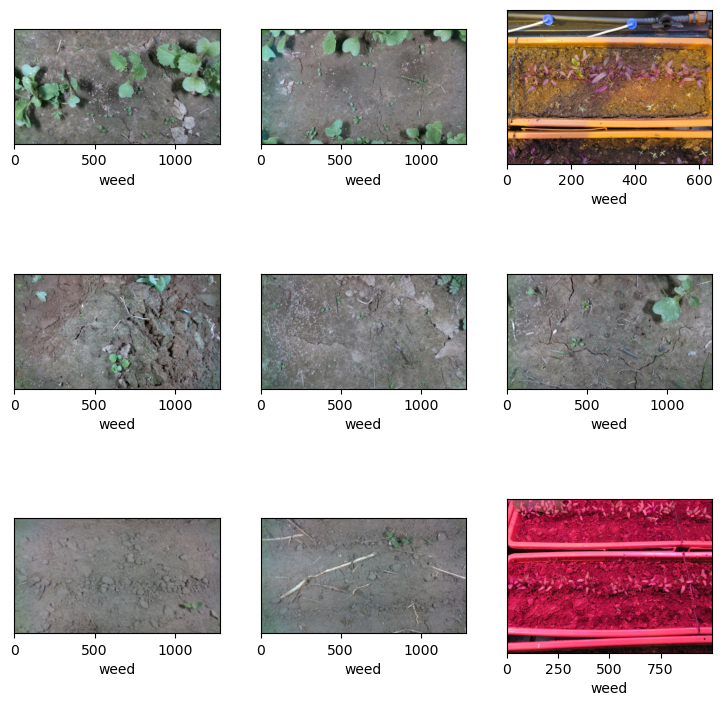

In [12]:
from skimage import io

nof_cols, nof_rows = 3, 3
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(nof_cols*3, nof_rows*3))

for ax in axes.flatten():
    ax.get_yaxis().set_ticks([])
    record = randint(0, len(ds))
    ax.set_xlabel(xlabel=ds[record][1])
    ax.imshow(io.imread(ds[record][0]))

### Notes:

**Dataset imbalance**: More weeds than crops.

**Minimum resolution**: Have to resize all images to match min resolution - uniformity.

## Get dataset resolution

In [13]:
#|export
from PIL import Image

def get_dataset_resolution_stats(ds):
    """
    Analyzes the dataset to find min, max, and average resolutions.
    """
    widths = []
    heights = []
    
    for each_img in ds:
        with Image.open(each_img[0]) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

    stats = {
        "min": (min(widths), min(heights)),
        "max": (max(widths), max(heights)),
        "avg": (sum(widths)//len(widths), sum(heights)//len(heights))
    }
    
    print(f"Stats: {stats}")
    return stats

In [14]:
get_dataset_resolution_stats(ds)

Stats: {'min': (360, 360), 'max': (1280, 1000), 'avg': (1177, 704)}


{'min': (360, 360), 'max': (1280, 1000), 'avg': (1177, 704)}

# Prepare dataset

In [15]:
#|export
from skimage import io, img_as_float

def load_image(ds):
    """
    Loads images into memory and converts to float [0, 1] range.
    """
    
    imgs = []
    c = 0
    for record in ds:
        img_path = record[0]
        img = io.imread(img_path) # normalized range is 0-1
        imgs.append(img_as_float(img))
        
    return imgs

In [16]:
%%time
X_imgs = load_image(ds)

AttributeError: 'list' object has no attribute 'shape'

In [29]:
len(X_imgs)

1176

In [61]:
# Free memory
gc.collect()

2812

In [62]:
y_labels = [lbl[1] for lbl in ds]

In [35]:
#|export
from skimage.transform import resize

def resize_images(imgs, target_size=(256, 256)):
    """
    Standardizes a list of images to a uniform resolution.
    """
    
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(resize(img, target_size, anti_aliasing=True))
    return resized_imgs

In [36]:
%%time
X_rez = resize_images(X_imgs)

In [40]:
print(len(X_rez))
del X_imgs
gc.collect()

1176


NameError: name 'X_imgs' is not defined

In [42]:
print(len(X_rez[0][0]), len(X_rez[0][1]))

256 256


---

Now that we have the list of image files, let's extract some features.

## Histogram of Oriented Gradients - HOG - Feature extraction

Used in shape recongnition.

For each image in the dataset:
1. Load image
2. Convert the image to grayscale
3. Resize the image to match min resolution
4. Extract HOG
5. Append to list with features

In [ ]:
%%time

X_hog_features, y_hog_labels, X_hog_visual = [], [], []
for i in range(len(ds)):
    
    img = cv2.imread(ds[i][0])
    img_resized = cv2.resize(img, (min_width, min_height))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    if i%200 == 0:
        
        # Sample visual image
        hog_features, hog_visual = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=True
        )
        X_hog_visual.append([ [i], [hog_visual] ])
        
    else:
        
        # Skip visual, just exctract features
        hog_features = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        
    # Collect features and labels
    X_hog_features.append(hog_features)
    y_hog_labels.append(ds[i][1])

In [5]:
len(X_hog_features), len(y_hog_labels)

(1176, 1176)

In [6]:
len(X_hog_features[0])

69696

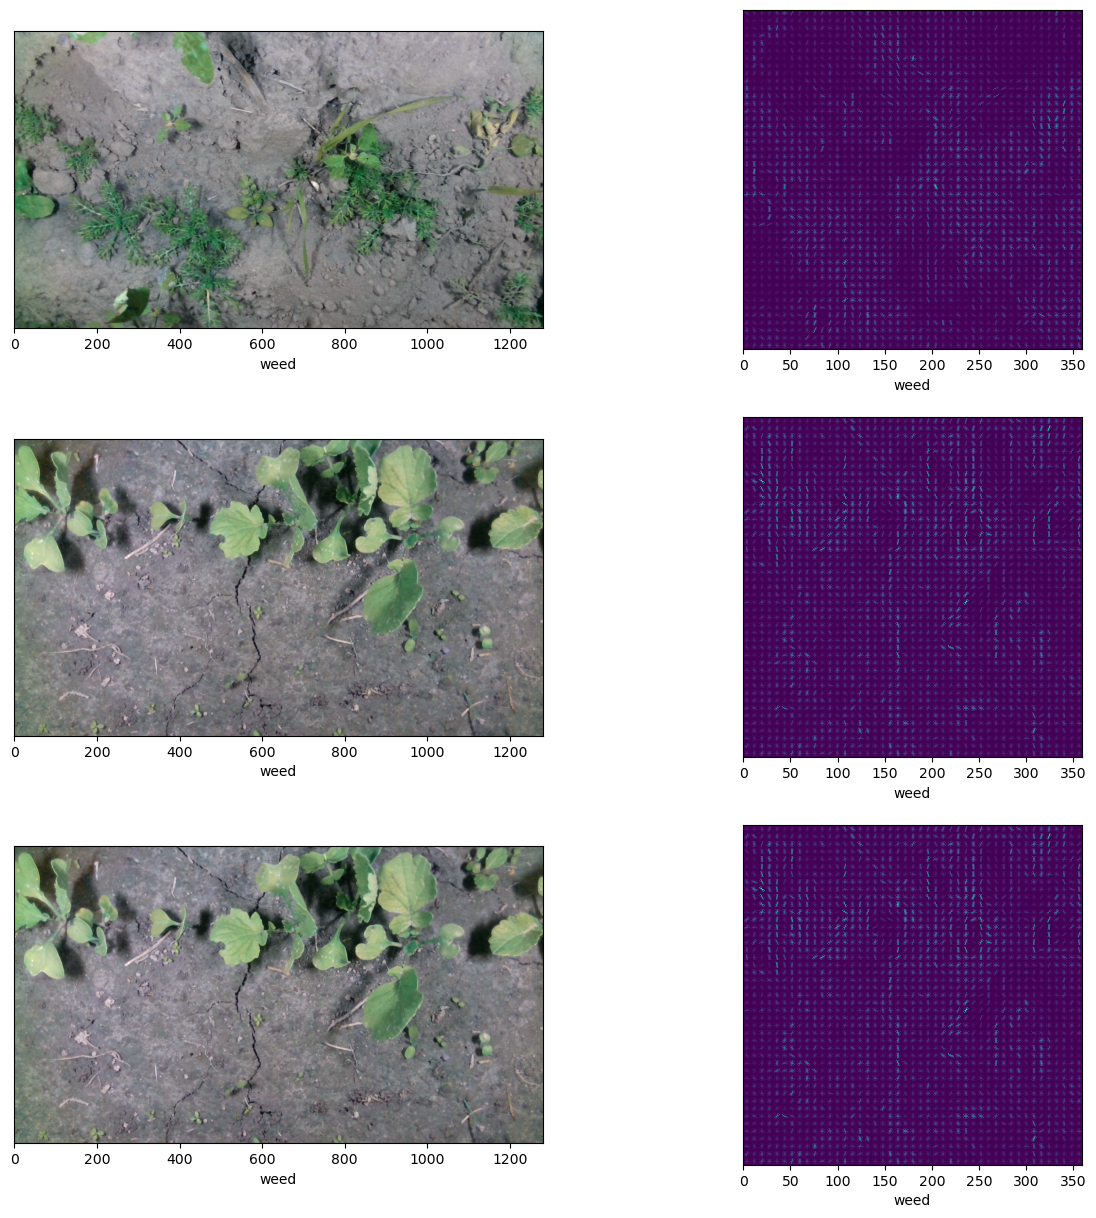

In [10]:
# How do images look like now?
nof_cols = 2
nof_rows = 3

fig, axes = plt.subplots(nrows=nof_rows, ncols=nof_cols, figsize=(15, 15))

for axs in axes:
    axs[0].get_yaxis().set_ticks([])
    axs[1].get_yaxis().set_ticks([])
    
    rand_record_visual = randint(0, len(X_hog_visual)-1)
    
    # Set label
    axs[0].set_xlabel(xlabel = ds[ X_hog_visual[ rand_record_visual ][0][0] ][1])
    axs[1].set_xlabel(xlabel = ds[ X_hog_visual[ rand_record_visual ][0][0] ][1])
    
    # Set images
    axs[0].imshow(cv2.imread(ds[X_hog_visual[rand_record_visual][0][0]][0]))
    axs[1].imshow(X_hog_visual[rand_record_visual][1][0])

In [44]:
#|export
from skimage.feature import hog
from skimage.color import rgb2gray

def extract_hog_features_from_list(X_images_rgb):
    """
    Takes a list of pre-resized RGB images and returns HOG features.
    """
    
    X_hog_features = []
    
    for img_rgb in X_images_rgb:
        # 1. Convert RGB to Gray using skimage
        img_gray = rgb2gray(img_rgb)

        # 2. Extract HOG
        hog_features = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )

        X_hog_features.append(hog_features)
        
    return np.array(X_hog_features)

In [47]:
%%time
X_hog_features = extract_hog_features_from_list(X_rez)

CPU times: user 15.8 s, sys: 72.9 ms, total: 15.8 s
Wall time: 15.8 s


In [51]:
# Amount of feature per image
len(X_hog_features[0])

34596

HOG extractecd, does not look so useful to the human eye at least.

---

# RandomForest classifier

**Notes**

Because the dataset is imbalanced, let's train a classifier with 2 classes, weed and not weed instead of weed and crop.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hog_features,
    y_labels,
    train_size=0.8,
    stratify=y_labels # Balances
)

In [64]:
print(
f"""Train samples: {len(X_train)}
Train labels: {len(y_train)}\n
Test samples: {len(X_test)}
Test labels: {len(y_test)}"""
)

Train samples: 940
Train labels: 940

Test samples: 236
Test labels: 236


In [65]:
%%time
classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

CPU times: user 3.58 s, sys: 7.53 ms, total: 3.59 s
Wall time: 3.6 s


## Evaluation

In [66]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.92%


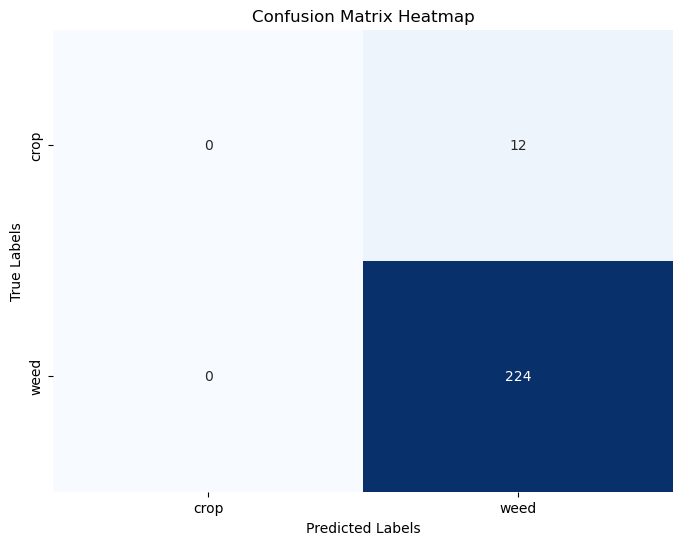

In [67]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["crop", "weed"], yticklabels=["crop", "weed"])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [68]:
print(f"Accuracy: {sum(conf_matrix.diagonal())/sum(conf_matrix.flatten())}")

Accuracy: 0.9491525423728814


In [69]:
recall_crop = conf_matrix[0][0]/conf_matrix[0].flatten().sum()
recall_weed = conf_matrix[1][1]/conf_matrix[1].flatten().sum()
print(f"Recall Crop: {recall_crop}")
print(f"Recall Weed: {recall_weed}")

Recall Crop: 0.0
Recall Weed: 1.0


**High Recall** (closer to 1.0 or 100%): Indicates the model is very good at identifying all existing positive instances, resulting in very few false negatives (missed cases).

**Low Recall** (closer to 0): Indicates the model misses a large percentage of the actual positive instances, leading to many false negatives

Low recall on the crop shows that the model is bad at finding crops among weeds.

Surely this has to do with the fact that the dataset is highly imbalanced and the model does not learn to recognize crops very well.

In [70]:
import math
precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()
if math.isnan(precision_crop):
    precision_crop = 0
prevision_weed = conf_matrix[1][1]/conf_matrix[:,1].sum()
print(f"Precision Crop: {precision_crop}")
print(f"Precision Weed: {prevision_weed}")

Precision Crop: 0
Precision Weed: 0.9491525423728814


/tmp/ipykernel_1097801/966795271.py:2: RuntimeWarning: invalid value encountered in scalar divide
  precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()


When the model sees a crop, it's highly certain that it's a crop. But, it does not dare to make that assumption many times. The models underfits for crop.

It makes more correct predictions for weed.

In [71]:
f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)
if math.isnan(f1_score_crop):
    f1_score_crop = 0
f1_score_weed = (2*prevision_weed*recall_weed)/(prevision_weed+recall_weed)
print(f"F1 score Crop: {f1_score_crop}")
print(f"F1 score Weed: {f1_score_weed}")

F1 score Crop: 0
F1 score Weed: 0.9739130434782608


/tmp/ipykernel_1097801/2006460474.py:1: RuntimeWarning: invalid value encountered in scalar divide
  f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)


Low F1-score for the Crop class indicates that the model made a lot of False-Positive predictions - missclassified Crop as Weed.

High F1-score for the Weed class indicates the model made a lot of True-Positive predictions - correctly classified the Weed class.

Let's calculate **Macro F1** which is especially important for imabalanced datasets.

In [72]:
f1_macro = (f1_score_crop + f1_score_weed) / 2
f1_macro

0.4869565217391304

As expected, `macro F1` is nowhere close to 1 which indicates a poor model performance for one of the classes.


Let's build the evaluation library.

In [75]:
#|export

def calculate_accuracy(y_test, y_preds):
    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

In [328]:
#|export

def evaluate(y_test, y_preds, print_cnfm=False):
    """
    RUn the evaluation on the model predictions.
    INPUTS:
        - y_test
        - y_preds
        - print_cnfm=False
    """

    # Accuracy sklearn
    accuracy_sklearn = calculate_accuracy(y_test, y_preds)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_preds)
    
    # Accuracy custom
    accuracy_custom = sum(conf_matrix.diagonal())/sum(conf_matrix.flatten())
    
    # Class recall
    recall_crop = conf_matrix[0][0]/conf_matrix[0].flatten().sum()
    recall_weed = conf_matrix[1][1]/conf_matrix[1].flatten().sum()

    # Class precision
    precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()
    if math.isnan(precision_crop):
        precision_crop = 0
    precision_weed = conf_matrix[1][1]/conf_matrix[:,1].sum()

    # Class f1 score
    f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)
    if math.isnan(f1_score_crop):
        f1_score_crop = 0
    f1_score_weed = (2*precision_weed*recall_weed)/(precision_weed+recall_weed)
    
    
    # F1 macro score
    f1_macro = (f1_score_crop + f1_score_weed) / 2
    
    if print_cnfm == True:
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["crop", "weed"], yticklabels=["crop", "weed"])

        plt.title('Confusion Matrix Heatmap')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    
    
    return {
        "Accuracy sklearn": accuracy_sklearn,
        "Accuracy custom": accuracy_custom,
        "Conf Matrix": conf_matrix,
        "Recall crop": recall_crop,
        "Recall weed": recall_weed,
        "Precision crop: (TP/(TP+FP))": precision_crop,
        "Precision weed": precision_weed,
        "F1 crop": f1_score_crop,
        "F1 weed": f1_score_weed,
        "F1 macro": f1_macro,
    }

Confirm it works.

/tmp/ipykernel_1097801/2077802505.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()
/tmp/ipykernel_1097801/2077802505.py:25: RuntimeWarning: invalid value encountered in scalar divide
  f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)


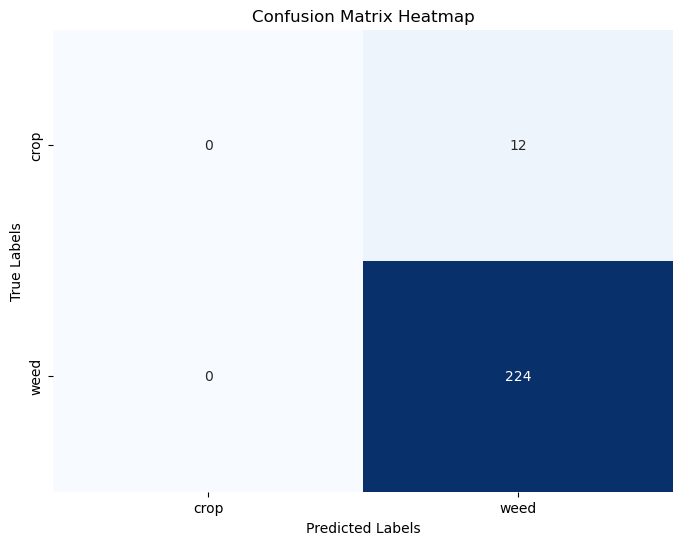

{'Accuracy sklearn': 0.9491525423728814,
 'Accuracy custom': 0.9491525423728814,
 'Conf Matrix': array([[  0,  12],
        [  0, 224]]),
 'Recall crop': 0.0,
 'Recall weed': 1.0,
 'Precision crop': 0,
 'Precision weed': 0.9491525423728814,
 'F1 crop': 0,
 'F1 weed': 0.9739130434782608,
 'F1 macro': 0.4869565217391304}

In [80]:
evaluate(y_test, y_pred, print_cnfm=True)

## Meeting with professor

- Test other classifiers.

1.Simplest-naive: balanced training dataset.

THrow away dominant class - with a more balanced ds.

2. Weighting on priors

3. Augmentation:

- SMOTE(features) only on train (on small sample)
- Measure macro-f1 score (different than just f1 score) - 2-3% improvement
- image augmentation - use ready


**Notes**

- Look for a library which can do augmentation automatically - don't reinvent the wheel.

---

# PyCaret

All in one feature extraction and model training library.


In [81]:
import pycaret.classification as clf
import pandas as pd

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7d493d9900>
Traceback (most recent call last):
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/master/.pyenv/versions/miniconda3-latest/envs/ml/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'spl

Create dataframe

In [82]:
img_path = []
for line in ds:
    img_path.append(line[0])

In [83]:
img_type = []
for line in ds:
    img_type.append(line[1])

In [84]:
df = pd.DataFrame({"image": img_path, "type": img_type})

In [85]:
df.head(5)

image  type
0  ../data/img/12114.jpg  weed
1  ../data/img/12120.jpg  weed
2  ../data/img/12122.jpg  weed
3  ../data/img/12123.jpg  weed
4  ../data/img/12147.jpg  weed

In [86]:
df.describe()

image  type
count                       1176  1176
unique                      1176     2
top     ../data/img/IMG_6203.JPG  weed
freq                           1  1116

In [87]:
df.type.unique()

array(['weed', 'crop'], dtype=object)

In [88]:
# Setup
clf.setup(data=df, target="type", session_id=123, fix_imbalance=True)

In [89]:
# Build and Compare models

best = clf.compare_models()

In [90]:
# Print best model
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [91]:
clf.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [92]:
gc.collect()

326

In [93]:
preds = clf.predict_model(best)

In [94]:
preds = clf.predict_model(best)
preds.head()

image  type prediction_label  prediction_score
81      ../data/img/32196.jpg  weed             weed            0.7715
771     ../data/img/34060.jpg  weed             weed            0.7715
361     ../data/img/32688.jpg  weed             weed            0.7715
803     ../data/img/34110.jpg  weed             weed            0.7715
957  ../data/img/IMG_5935.JPG  weed             weed            0.7715

In [95]:
preds.shape

(353, 4)

In [96]:
clf.get_config('X_train')

image
300      ../data/img/32536.jpg
275      ../data/img/32502.jpg
253      ../data/img/32479.jpg
1137  ../data/img/IMG_6164.JPG
1095  ../data/img/IMG_6112.JPG
...                        ...
56       ../data/img/32171.jpg
892      ../data/img/37095.jpg
336      ../data/img/32615.jpg
916      ../data/img/37683.jpg
808      ../data/img/34122.jpg

[823 rows x 1 columns]

---

# Local Binary Pattern - LBP

For each image in the dataset:
1. Load image
2. Convert the image to grayscale
3. Resize the image to match min resolution
4. Extract LBP
5. Get the histogram of LBP
6. Append to list with features

In [282]:
#|export

from skimage import feature

def extract_lbp_features(ds):
    """
    This original version uses OpenCV to laod the image. OpenCV uses the BGR color format.
    
    See newer version instead!
    """
    
    X_lbp_features, y_lbp_labels = [], []
    min_width, min_height = weedcrop.dataset.find_min_dim(ds)
    
    for i in range(len(ds)):
        img = cv2.imread(ds[i][0])
        img_resized = cv2.resize(img, (min_width, min_height))
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        lbp = feature.local_binary_pattern(img_gray, P=8, R=1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)        

        # Collect features and labels
        X_lbp_features.append(lbp_hist)
        y_lbp_labels.append(ds[i][1])
    return X_lbp_features, y_lbp_labels

In [37]:
%%time
X_lbp_features, y_lbp_labels = extract_lbp_features(ds)
len(X_lbp_features), len(y_lbp_labels)

Minimum resolution: (360, 360)
CPU times: user 17.5 s, sys: 848 ms, total: 18.3 s
Wall time: 17.2 s


(1176, 1176)

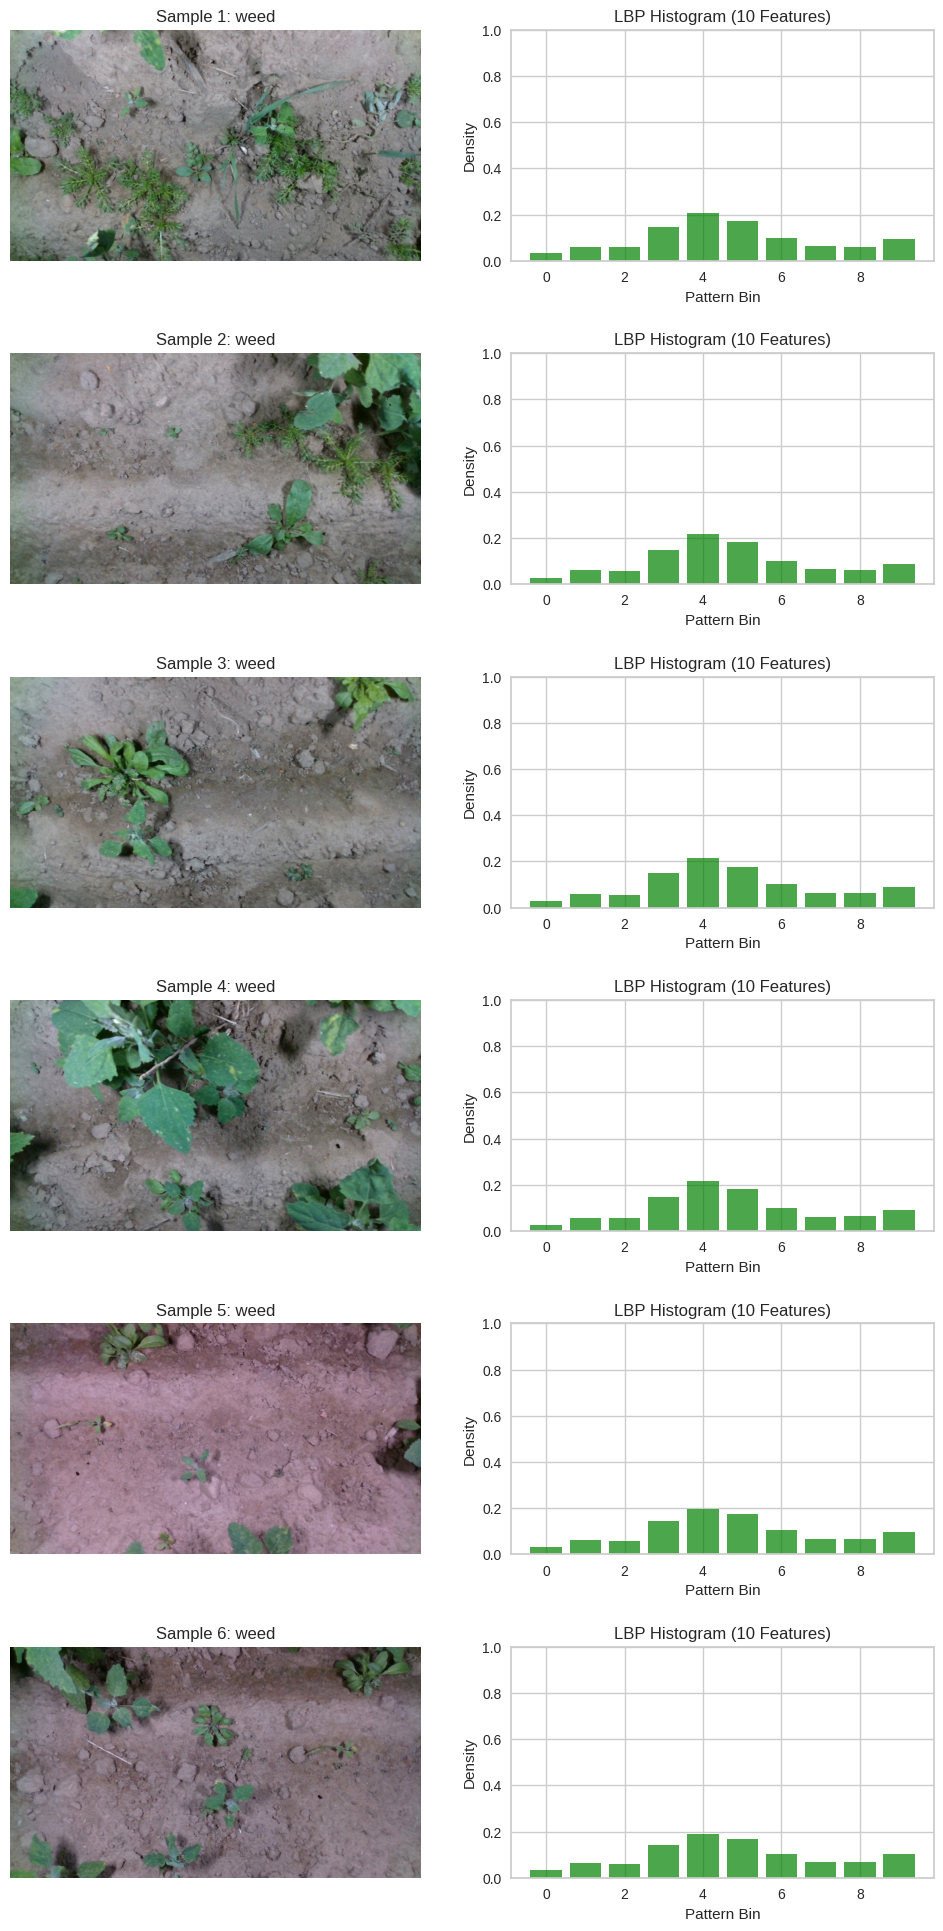

CPU times: user 1.57 s, sys: 178 ms, total: 1.75 s
Wall time: 1.53 s


In [38]:
%%time

import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

# 1. Setup the figure
fig, axes = plt.subplots(6, 2, figsize=(12, 24))
plt.subplots_adjust(hspace=0.4)

# 2. Loop through 6 samples
for i in range(6):
    # Load and process image
    img_path = ds[i][0]
    label = ds[i][1]
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate LBP (Texture)
    # P=8, R=1, 'uniform' matches your extraction function
    lbp = local_binary_pattern(img_gray, P=8, R=1, method='uniform')
    
    # Calculate Histogram
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    # Plot Image
    axes[i, 0].imshow(img_rgb)
    axes[i, 0].set_title(f"Sample {i+1}: {label}")
    axes[i, 0].axis('off')

    # Plot Histogram
    axes[i, 1].bar(range(n_bins), hist, color='green', alpha=0.7)
    axes[i, 1].set_title(f"LBP Histogram (10 Features)")
    axes[i, 1].set_xlabel("Pattern Bin")
    axes[i, 1].set_ylabel("Density")
    axes[i, 1].set_ylim(0, 1)

plt.show()

In [100]:
#|export
from skimage import feature, color
import numpy as np

def extract_lbp_features_from_list(X_images_rgb):
    """
    Standardized LBP extraction using pre-resized RGB images.
    """
    
    X_lbp_features = []
    
    for img_rgb in X_images_rgb:
        # 1. Convert RGB to Gray
        img_gray = color.rgb2gray(img_rgb)

        # 2. Extract LBP
        lbp = feature.local_binary_pattern(img_gray, P=8, R=1, method='uniform')
        
        # 3. Create Histogram (10 bins for P=8 uniform)
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)

        X_lbp_features.append(lbp_hist)
        
    return np.array(X_lbp_features)

In [101]:
%%time
X_lbp_features = extract_lbp_features_from_list(X_rez)

CPU times: user 5.89 s, sys: 0 ns, total: 5.89 s
Wall time: 5.91 s


In [103]:
len(X_lbp_features[0])

10

Just 10 features, that's good. Unlike HOG...

In [105]:
# Run random forest on these features only
X_train, X_test, y_train, y_test = train_test_split(
    X_lbp_features,
    y_labels,
    train_size=0.8,
    stratify=y_labels # Balances
)

In [106]:
%%time
classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

CPU times: user 133 ms, sys: 0 ns, total: 133 ms
Wall time: 132 ms


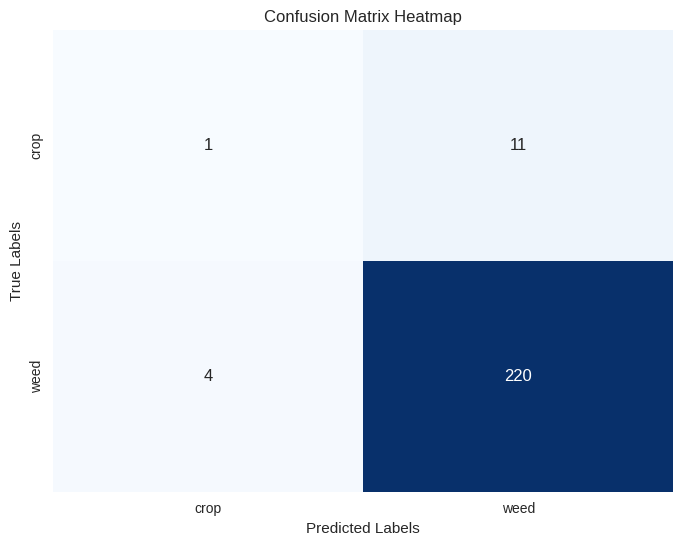

{'Accuracy sklearn': 0.9364406779661016,
 'Accuracy custom': 0.9364406779661016,
 'Conf Matrix': array([[  1,  11],
        [  4, 220]]),
 'Recall crop': 0.08333333333333333,
 'Recall weed': 0.9821428571428571,
 'Precision crop': 0.2,
 'Precision weed': 0.9523809523809523,
 'F1 crop': 0.11764705882352941,
 'F1 weed': 0.967032967032967,
 'F1 macro': 0.5423400129282482}

In [110]:
evaluate(y_test, y_pred, print_cnfm=True)

In [111]:
gc.collect()

4244

# Feature Fusion

Create a single "super-vector" that contains all features.

In [115]:
len(X_hog_features[0])

34596

In [116]:
len(X_lbp_features[0])

10

In [117]:
# Original
X_hog = np.array(X_hog_features)
X_lbp = np.array(X_lbp_features)

X_combined = np.hstack([X_hog, X_lbp])

X_combined.shape, X_combined[0].shape

((1176, 34606), (34606,))

In [118]:
del X_hog, X_lbp, X_combined

In [243]:
#|export
def feature_fusion(super_matrix:np.ndarray=None, feature_list:list =[]):
    """
    Fuses a list of features into a super-matrix.
    """
    
    new_features = [np.array(f) for f in feature_list]
    
    if super_matrix is None:
        super_matrix = np.hstack([ np.array(f) for f in feature_list ])
        
    else:
        super_matrix = np.hstack([super_matrix] + new_features)
        
    return super_matrix

In [244]:
%%time
X_combined = feature_fusion(feature_list=[X_hog_features, X_lbp_features])
X_combined.shape

NameError: name 'X_hog_features' is not defined

---

# Retrain Random Forest with LBP + HOG

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_labels,
    train_size=0.8,
    stratify=y_labels # Fix imbalance
)

In [123]:
print(
f"""Train samples: {len(X_train)}
Train labels: {len(y_train)}\n
Test samples: {len(X_test)}
Test labels: {len(y_test)}"""
)

Train samples: 940
Train labels: 940

Test samples: 236
Test labels: 236


In [124]:
%%time
classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",
    criterion="gini"
)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

CPU times: user 3.57 s, sys: 11.4 ms, total: 3.59 s
Wall time: 3.59 s


In [125]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 94.92%


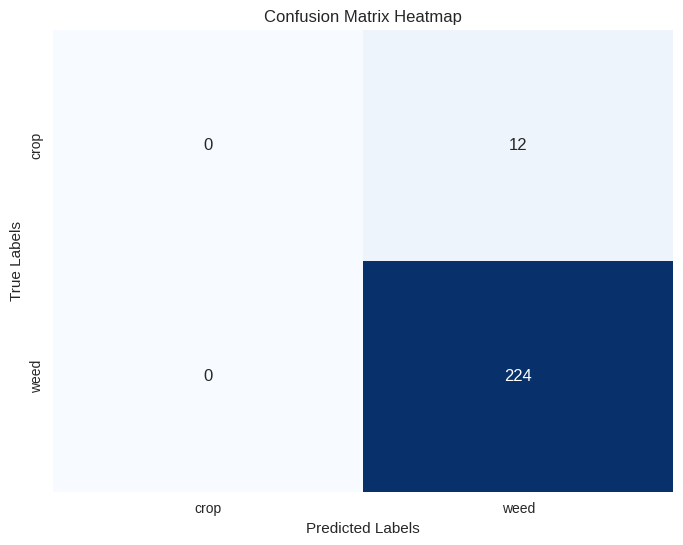

In [126]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=["crop", "weed"], yticklabels=["crop", "weed"])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [127]:
print(f"Accuracy: {sum(conf_matrix.diagonal())/sum(conf_matrix.flatten())}")

Accuracy: 0.9491525423728814


In [128]:
recall_crop = conf_matrix[0][0]/conf_matrix[0].flatten().sum()
recall_weed = conf_matrix[1][1]/conf_matrix[1].flatten().sum()
print(f"Recall Crop: {recall_crop}")
print(f"Recall Weed: {recall_weed}")

Recall Crop: 0.0
Recall Weed: 1.0


**High Recall** (closer to 1.0 or 100%): Indicates the model is very good at identifying all existing positive instances, resulting in very few false negatives (missed cases).

**Low Recall** (closer to 0): Indicates the model misses a large percentage of the actual positive instances, leading to many false negatives

Low recall on the crop shows that the model is bad at finding crops among weeds.

Surely this has to do with the fact that the dataset is highly imbalanced and the model does not learn to recognize crops very well.

In [129]:
import math
precision_crop = conf_matrix[0][0]/conf_matrix[:,0].sum()
if math.isnan(precision_crop):
    precision_crop = 0
prevision_weed = conf_matrix[1][1]/conf_matrix[:,1].sum()
print(f"Precision Crop: {precision_crop}")
print(f"Precision Weed: {prevision_weed}")

Precision Crop: 0
Precision Weed: 0.9491525423728814


When the model sees a crop, it's highly certain that it's a crop. But, it does not dare to make that assumption many times. The models underfits for crop.

It makes more correct predictions for weed.

In [130]:
f1_score_crop = (2*precision_crop*recall_crop)/(precision_crop+recall_crop)
if math.isnan(f1_score_crop):
    f1_score_crop = 0
f1_score_weed = (2*prevision_weed*recall_weed)/(prevision_weed+recall_weed)
print(f"F1 score Crop: {f1_score_crop}")
print(f"F1 score Weed: {f1_score_weed}")

F1 score Crop: 0
F1 score Weed: 0.9739130434782608


Low F1-score for the Crop class indicates that the model made a lot of False-Positive predictions - missclassified Crop as Weed.

High F1-score for the Weed class indicates the model made a lot of True-Positive predictions - correctly classified the Weed class.

Let's calculate **Macro F1** which is especially important for imabalanced datasets.

https://medium.com/@sushma.mullamuri420/understanding-the-macro-f1-score-in-multi-class-classification-21ca00c200da

In [131]:
f1_macro = (f1_score_crop + f1_score_weed) / 2
f1_macro

0.4869565217391304

No significant improvement when using LBP + HOG.

---

# Imbalanced RandomForestClassifier (LBP+HOG)

This is something I discoreved that can help me solve my class imbalance.



In [134]:
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True)
model.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                               class_weight=None, criterion='gini',
                               max_depth=None, max_features='sqrt',
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=1,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, monotonic_cst=None,
                               n_estimators=100, n_jobs=None, oob_score=False,
                               random_state=None, replacement=True,
                               sampling_strategy='all', verbose=0,
                               warm_start=False)

In [135]:
y_pred = model.predict(X_test)

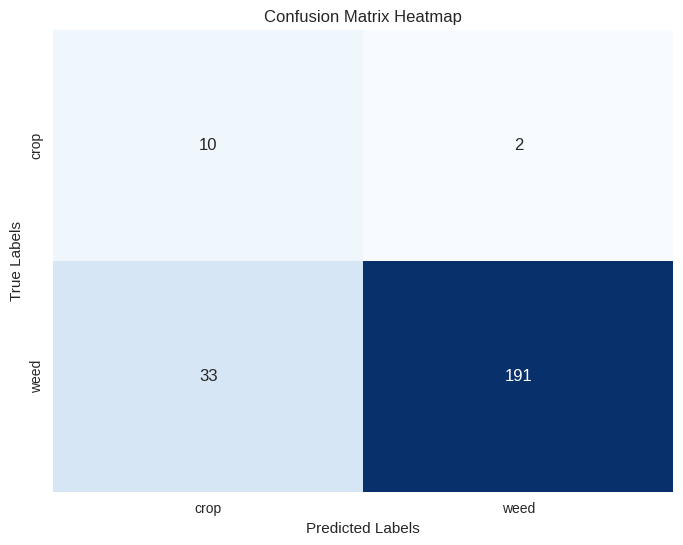

{'Accuracy sklearn': 0.8516949152542372,
 'Accuracy custom': 0.8516949152542372,
 'Conf Matrix': array([[ 10,   2],
        [ 33, 191]]),
 'Recall crop': 0.8333333333333334,
 'Recall weed': 0.8526785714285714,
 'Precision crop': 0.23255813953488372,
 'Precision weed': 0.9896373056994818,
 'F1 crop': 0.3636363636363636,
 'F1 weed': 0.9160671462829736,
 'F1 macro': 0.6398517549596686}

In [137]:
evaluate(y_test, y_pred, print_cnfm=True)

Let's set the undersampling for the "majority" class.

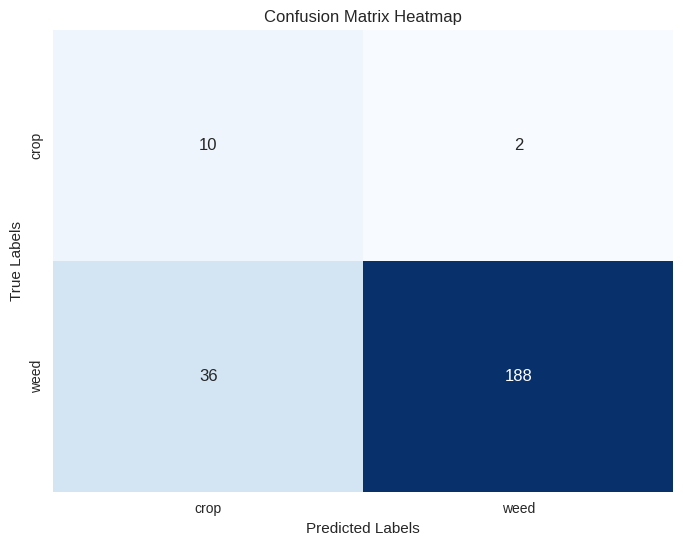

{'Accuracy sklearn': 0.8389830508474576,
 'Accuracy custom': 0.8389830508474576,
 'Conf Matrix': array([[ 10,   2],
        [ 36, 188]]),
 'Recall crop': 0.8333333333333334,
 'Recall weed': 0.8392857142857143,
 'Precision crop': 0.21739130434782608,
 'Precision weed': 0.9894736842105263,
 'F1 crop': 0.3448275862068966,
 'F1 weed': 0.9082125603864734,
 'F1 macro': 0.6265200732966849}

In [142]:
model = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="majority", replacement=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred, print_cnfm=True)

In [223]:
gc.collect()

482

### Create function for Imbalanced random forest classifier

In [331]:
#|export

from imblearn.ensemble import BalancedRandomForestClassifier

def test_imbalanced_forest_classifier(X_features:list, y_labels:list, train_split:float=0.8, class_weight=None):
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_features,
        y_labels,
        train_size=train_split,
        stratify=y_labels # Fix imbalance
    )
    
    # Train model
    model = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="all", replacement=True, class_weight=class_weight)
    model.fit(X_train, y_train)
    
    # Run preds
    y_preds = model.predict(X_test)
    
    # Evaluate
    return evaluate(y_test, y_preds, print_cnfm=True)

# Feature reduction

HOG carries a lot of features, we need to reduce them and run the models again.

Refs:

- https://github.com/gpetrousov/pca_lta_assignment_demokritos/blob/master/pca_lta_showcase.ipynb
- https://stackoverflow.com/questions/23838056/what-is-the-difference-between-transform-and-fit-transform-in-sklearn


In [168]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [173]:
# Standardize the data (Mean=0, StdDev=1)
X_hog_scaled = StandardScaler().fit_transform(X_hog_features)

In [209]:
# Sanity check
round(np.mean(X_hog_scaled)), round(np.std(X_hog_scaled))

(0, 1)

In [207]:
# Nof initial components/features we have
len(X_hog_scaled[0])

34596

In [200]:
%%time
# Apply PCA
pca_check = PCA(n_components=800)
pca_check.fit(X_hog_scaled)

CPU times: user 45.3 s, sys: 28 s, total: 1min 13s
Wall time: 11.2 s


PCA(copy=True, iterated_power='auto', n_components=800, n_oversamples=10,
    power_iteration_normalizer='auto', random_state=None, svd_solver='auto',
    tol=0.0, whiten=False)

In [201]:
# Extract variance
variance_ratio = pca_check.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

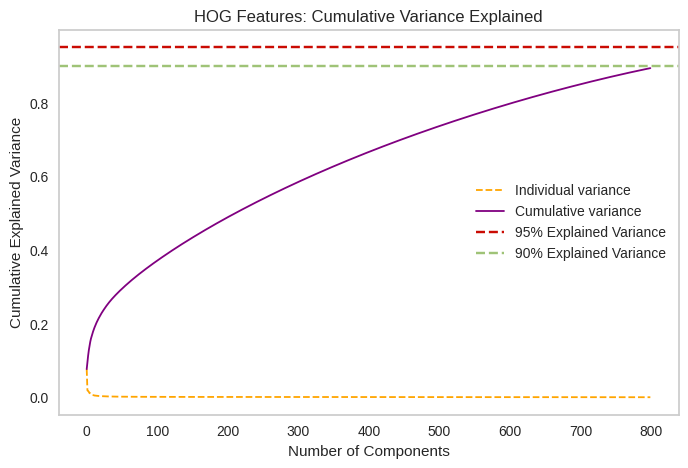

In [202]:
# Plot the Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(variance_ratio, linewidth=1.3, linestyle="--", color="orange", label="Individual variance")
plt.plot(cumulative_variance, linewidth=1.3, linestyle="-", color="purple", label="Cumulative variance")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('HOG Features: Cumulative Variance Explained')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Explained Variance')
plt.legend()
plt.grid()
plt.show()

In [206]:
# Cumulative variance for component explainability ~90%
cumulative_variance[-1]

0.8932506879091603

Final number of components 800

In [212]:
pca_apply = PCA(n_components=800)
X_hog_reduced = pca_apply.fit_transform(X_hog_scaled)

In [215]:
len(X_hog_reduced[0])

800

In [225]:
gc.collect()
del X_hog_features, X_hog_scaled

NameError: name 'X_hog_features' is not defined

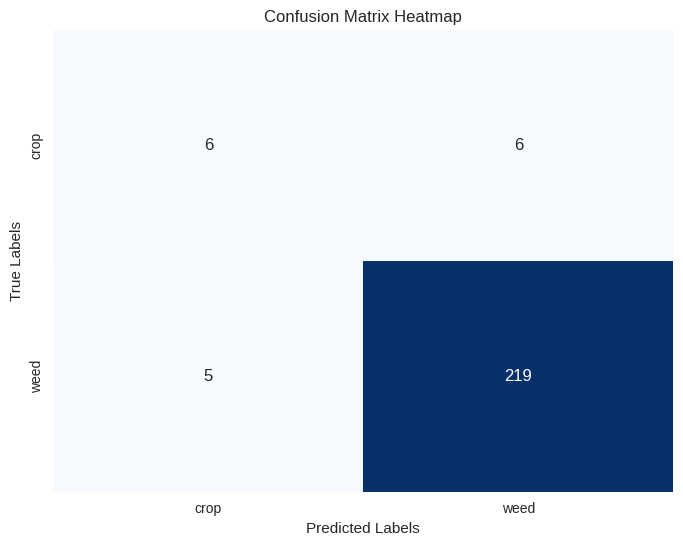

{'Accuracy sklearn': 0.9533898305084746,
 'Accuracy custom': 0.9533898305084746,
 'Conf Matrix': array([[  6,   6],
        [  5, 219]]),
 'Recall crop': 0.5,
 'Recall weed': 0.9776785714285714,
 'Precision crop': 0.5454545454545454,
 'Precision weed': 0.9733333333333334,
 'F1 crop': 0.5217391304347826,
 'F1 weed': 0.9755011135857461,
 'F1 macro': 0.7486201220102644}

In [231]:
# Test only for HOG features
test_imbalanced_forest_classifier(X_hog_reduced, y_labels)

In [246]:
# Test only for HOG+LBP features
X_combined = feature_fusion(feature_list=[X_hog_reduced, X_lbp_features])
X_combined.shape

(1176, 810)

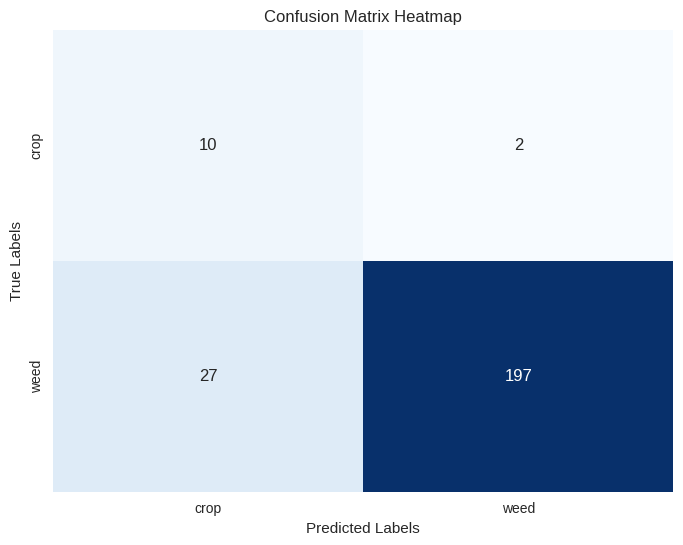

{'Accuracy sklearn': 0.8771186440677966,
 'Accuracy custom': 0.8771186440677966,
 'Conf Matrix': array([[ 10,   2],
        [ 27, 197]]),
 'Recall crop': 0.8333333333333334,
 'Recall weed': 0.8794642857142857,
 'Precision crop': 0.2702702702702703,
 'Precision weed': 0.9899497487437185,
 'F1 crop': 0.4081632653061225,
 'F1 weed': 0.9314420803782505,
 'F1 macro': 0.6698026728421865}

In [248]:
test_imbalanced_forest_classifier(X_combined, y_labels)

These missclassification is much lower than when using only HOG or only LBP fetures.

---

# RGB to HSV

Hue Saturation Value - HSV is useful in extracing shapes from the images thus performing segmentation.

By extracting the HSV channels we can analyze the patterns in the images. The goal is to extract the green parts (plants & weeds) from the brown/grey soil and pots.

Reference: https://scikit-image.org/docs/0.25.x/auto_examples/color_exposure/plot_rgb_to_hsv.html

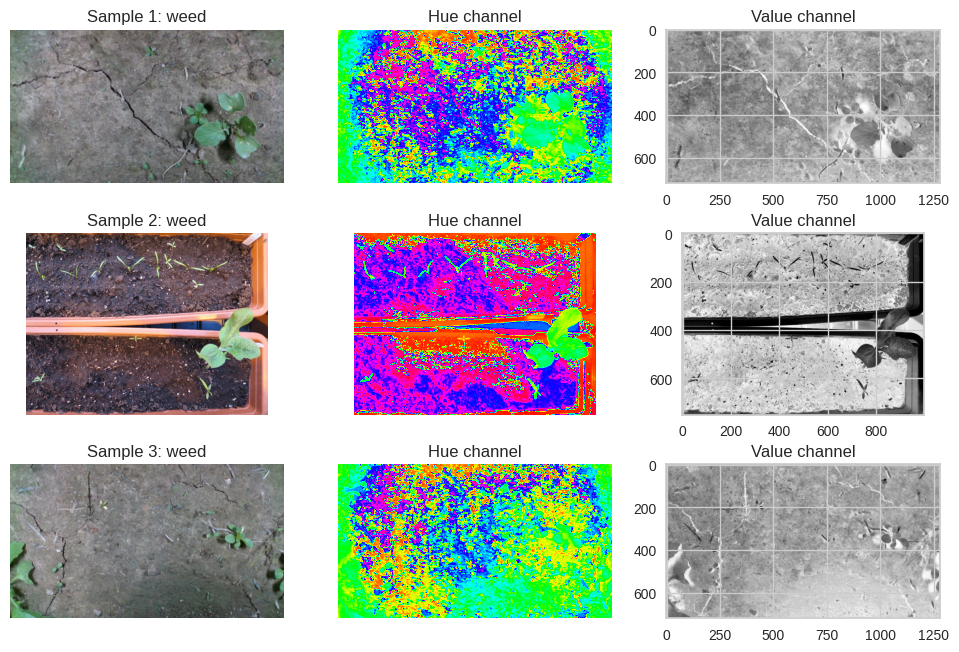

CPU times: user 1.12 s, sys: 178 ms, total: 1.3 s
Wall time: 1.11 s


In [272]:
%%time

import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from skimage.color import rgb2hsv


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

sample_index = []

for i in range(3):
    # Load and process image
    index = randint(0, len(ds)-1)
    sample_index.append(index)
    img_path = ds[index][0]
    label = ds[index][1]
    
    # Extract image features
    bgr_img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    hsv_img = rgb2hsv(rgb_img)
    hue_img = hsv_img[:, :, 0] # Hue channel
    sat_img = hsv_img[:, :, 1] # Saturation channel
    value_img = hsv_img[:, :, 2] # Value channel

    # Plot RGB img
    axes[i, 0].imshow(rgb_img)
    axes[i, 0].set_title(f"Sample {i+1}: {label}")
    axes[i, 0].axis("off")

    # Plot Hue img
    axes[i, 1].imshow(hue_img, cmap="hsv")
    axes[i, 1].set_title("Hue channel")
    axes[i, 1].axis("off")
    
    # Plot Value image
    axes[i, 2].imshow(value_img)
    axes[i, 2].set_title("Value channel")
    axes[i, 1].axis("off")

    
plt.show()

## Filter on the Hue channel

We need to **extract the greenery from the images**. To do that, we need to extract the **region** of the hue histogram which contains the greenery of the plant. This capture will return the shape of the plant and discard the surrounding data we don't need.

**NOTE: The region is valid when using RGB and not BRG (OpenCV default)!**

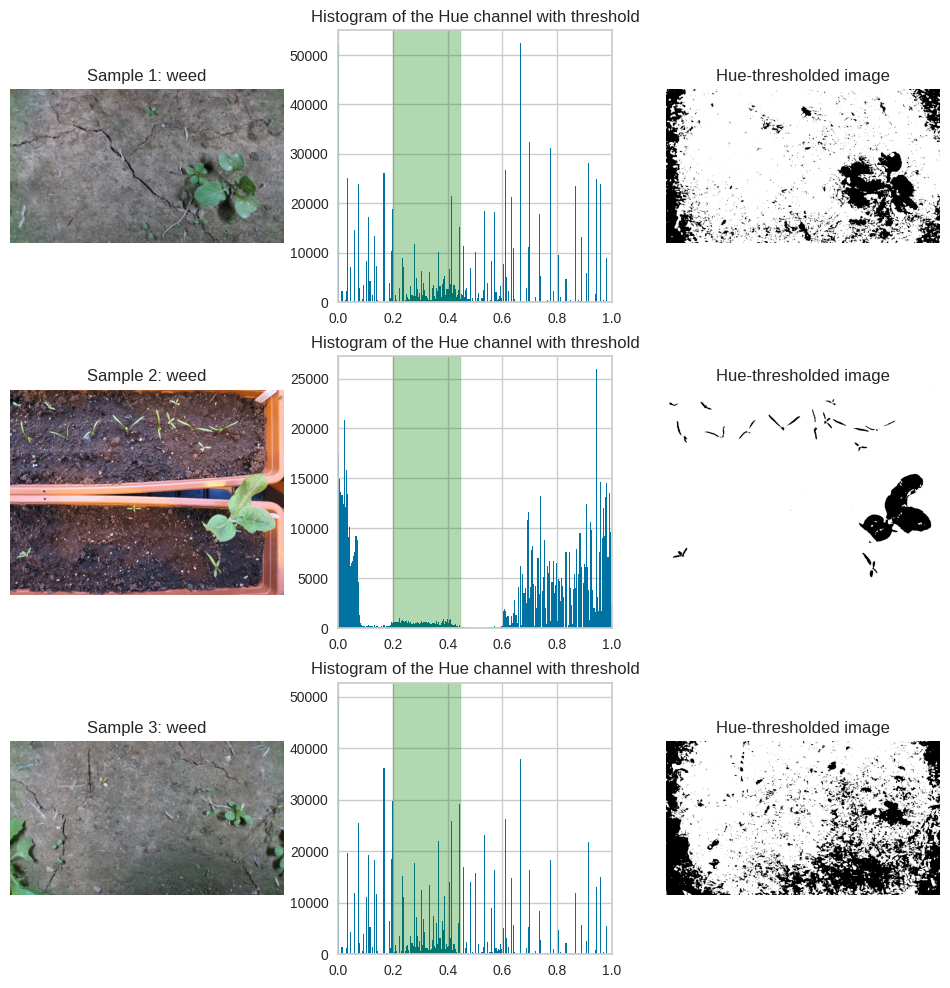

In [276]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Experimental threshold.
hue_lower_bound = 0.2
hue_upper_bound = 0.45

for img_index, i in zip(sample_index, range(3)):
    img_path = ds[img_index][0]
    label = ds[img_index][1]
    
    # Extract image features
    bgr_img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    hsv_img = rgb2hsv(rgb_img)
    hue_img = hsv_img[:, :, 0] # Hue channel
    
    # Apply filter
    binary_img = (hue_img > hue_lower_bound) & (hue_img < hue_upper_bound)
    
    # Plot RGB img
    axes[i, 0].imshow(rgb_img)
    axes[i, 0].set_title(f"Sample {i+1}: {label}")
    axes[i, 0].axis("off")
    
    # Plot Hue histogram
    axes[i, 1].hist(hue_img.ravel(), bins=254, range=(0, 1))
    axes[i, 1].set_title("Histogram of the Hue channel with threshold")
    axes[i, 1].axvspan(hue_lower_bound, hue_upper_bound, color="green", alpha=0.3, label="Plant Range")
    axes[i, 1].set_xbound(0, 1)
    
    # Plot filtered image
    axes[i, 2].imshow(binary_img)
    axes[i, 2].set_title("Hue-thresholded image")
    axes[i, 2].axis("off")


We want to capture as much information about the plant as possible, but focus on removing any garbage from the image. So, we set the filter to sacrifice a bit of the information on the plant but remove a large chunck of the garbage as well.

With the above, we have extracted the:

```python
# Experimental threshold.
hue_lower_bound = 0.2
hue_upper_bound = 0.45
```

The last image clearly shows that Hue channel alone is not enough. We don't capture enough information on it. So, we're also going to involve the Saturation channel in order to extract the shapes of the leaves.

**Can we do something similar for the Saturation channel?**

## Filter on the Saturation channel

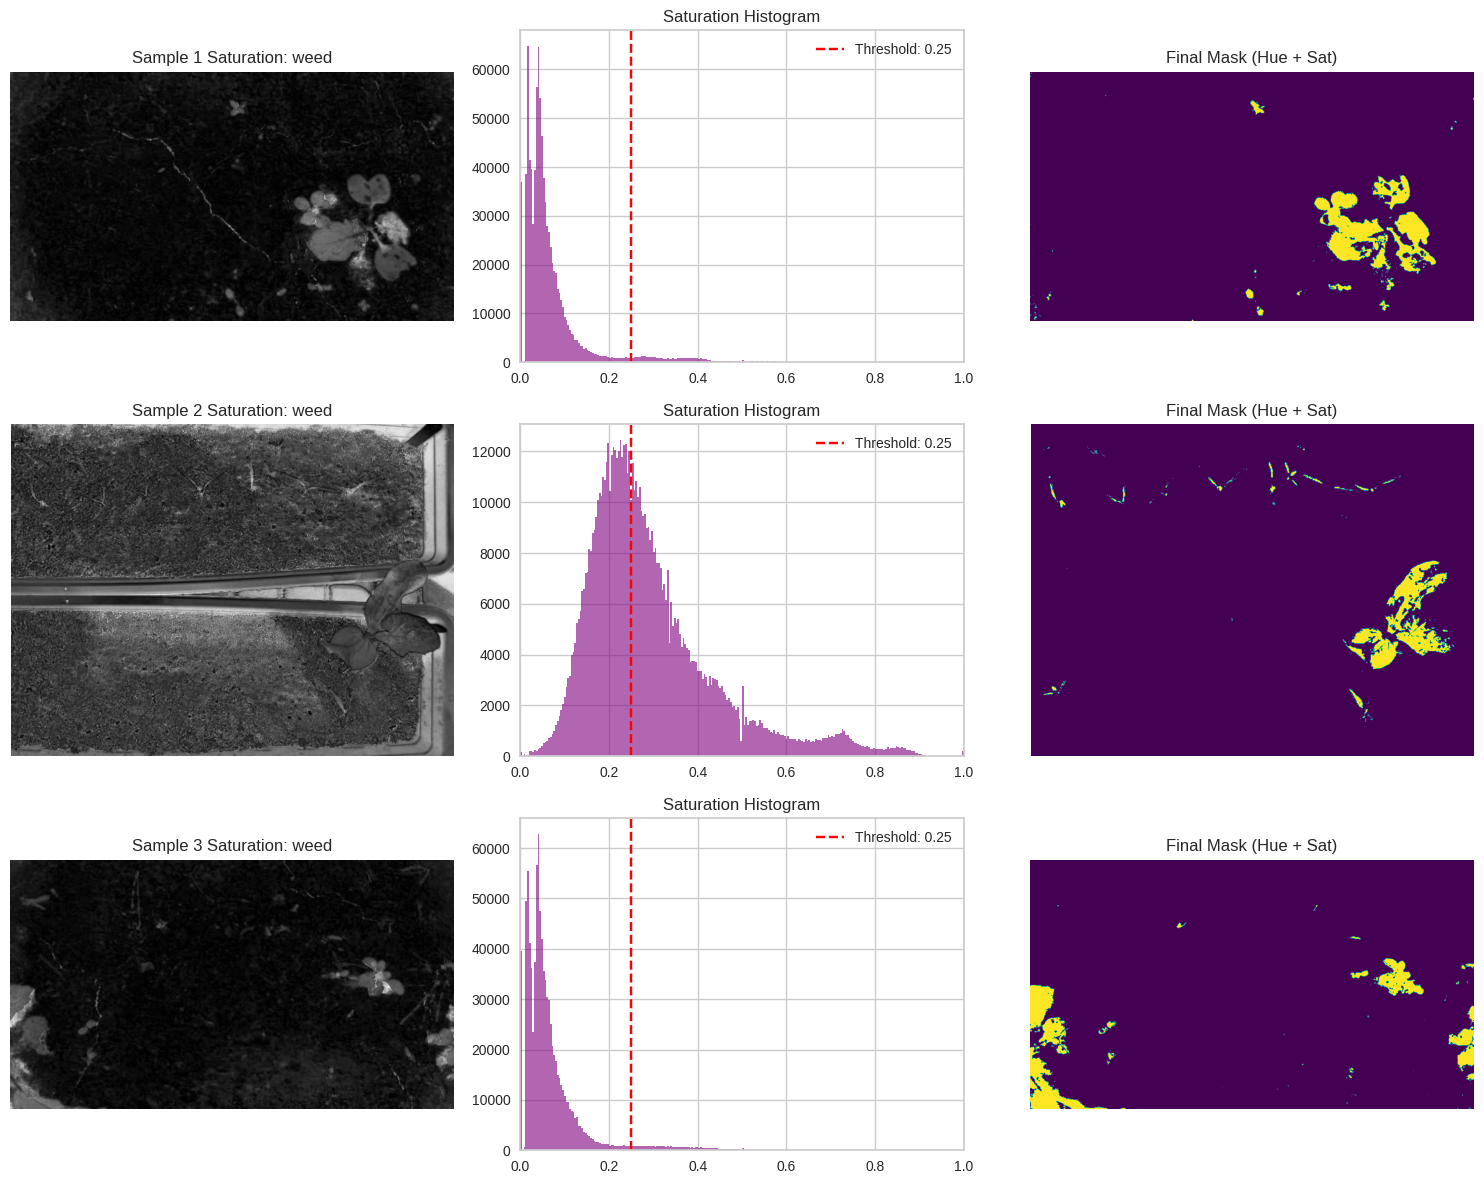

In [280]:
import matplotlib.pyplot as plt
import cv2
from skimage.color import rgb2hsv
import numpy as np

# Experiment with saturation values
sat_lower = 0.25  # Starting guess for Saturation threshold

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Using your existing sample_index list
for img_index, i in zip(sample_index, range(3)):
    img_path = ds[img_index][0]
    label = ds[img_index][1]
    
    # Load
    rgb_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    hsv_img = rgb2hsv(rgb_img)
    
    hue_img = hsv_img[:, :, 0]
    sat_img = hsv_img[:, :, 1]
    
    # Apply Combined Filter (Hue AND Saturation)
    # This ensures it's the right color AND vivid enough to be a plant
    combined_mask = (hue_img > hue_lower_bound) & (hue_img < hue_upper_bound) & (sat_img > sat_lower)
    
    # 1. Plot Saturation Grayscale Image
    # Bright areas = high saturation (plants), Dark areas = low saturation (soil)
    axes[i, 0].imshow(sat_img, cmap="gray")
    axes[i, 0].set_title(f"Sample {i+1} Saturation: {label}")
    axes[i, 0].axis("off")

    # 2. Plot Saturation Histogram
    axes[i, 1].hist(sat_img.ravel(), bins=254, range=(0, 1), color="purple", alpha=0.6)
    axes[i, 1].set_title("Saturation Histogram")
    axes[i, 1].axvline(sat_lower, color='red', linestyle='--', label=f"Threshold: {sat_lower}")
    axes[i, 1].set_xlim(0, 1)
    axes[i, 1].legend()
    
    # 3. Plot Resulting Combined Mask
    axes[i, 2].imshow(combined_mask, cmap="viridis")
    axes[i, 2].set_title("Final Mask (Hue + Sat)")
    axes[i, 2].axis("off")

fig.tight_layout()
plt.show()

From the above experimentation we extracted:
    
```python
sat_lower = 0.25
```

## Create function for HSV data extraction

In [323]:
#|export

from skimage import feature, color
import numpy as np

def extract_hsv_features_from_list(X_images_rgb, hue_lower_bound=0.2, hue_upper_bound=0.45, sat_lower=0.25, bins=10):
    """
    Standardized HSV extraction using pre-resized RGB images.
    """
    
    X_hsv_features = []
    
    for img_rgb in X_images_rgb:
        
        # 1. Extract channels
        hsv_img = rgb2hsv(img_rgb)
        hue_chan = hsv_img[:, :, 0]
        sat_chan = hsv_img[:, :, 1]
        val_chan = hsv_img[:, :, 2]

        # 2. Build mask
        hsv_mask = (hue_chan > hue_lower_bound) & (hue_chan < hue_upper_bound) & (sat_chan > sat_lower)
        
        # 3. Apply mask
        plant_hue = hue_chan[hsv_mask]
        plant_sat = sat_chan[hsv_mask]
        plant_val = val_chan[hsv_mask]

        # 4. Create Histogram for each channel
        if plant_hue.size > 0:
            hue_hist, _ = np.histogram(plant_hue, bins=bins, range=(0, 1), density=True)
            sat_hist, _ = np.histogram(plant_sat, bins=bins, range=(0, 1), density=True)
            val_hist, _ = np.histogram(plant_val, bins=bins, range=(0, 1), density=True)
        else:
            print("Zeroed image")
            hue_hist = np.zeros(bins)
            sat_hist = np.zeros(bins)
            val_hist = np.zeros(bins)

        # 5. Combine channels into one vector
        hsv_vector = np.concatenate([hue_hist, sat_hist, val_hist]) # Flat
        
        # 6. Append to feature list
        X_hsv_features.append(hsv_vector)
        
    return np.array(X_hsv_features)

In [312]:
%%time
X_hsv_features = extract_hsv_features_from_list(X_rez)

Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
Zeroed image
CPU times: user 9.77 s, sys: 0 ns, total: 9.77 s
Wall time: 9.78 s


In [313]:
# Default: 10 bins, 3 channels = 30
X_hsv_features.shape

(1176, 30)

In [314]:
# I used this to fix the presence of zeroes when calculating teh histograms
print(f"Any NaNs in HSV features? {np.isnan(X_hsv_features).any()}")

Any NaNs in HSV features? False


In [324]:
# Checkout which samples got zeroes from the HSV analysis
# 1. Sum the absolute values of each row
# If a row is all zeros, its sum will be 0.0
row_sums = np.abs(X_hsv_features).sum(axis=1)

# 2. Find where the sum is exactly 0
is_zero_row = (row_sums == 0)

# 3. Check for crops and weeds separately
zero_crop_indices = np.where(is_zero_row & (np.array(y_labels) == 'crop'))[0]
zero_weed_indices = np.where(is_zero_row & (np.array(y_labels) == 'weed'))[0]

print(f"Total zeroed images found by code: {np.sum(is_zero_row)}")
print(f"Zeroed crops: {zero_crop_indices}")
print(f"Zeroed weeds: {zero_weed_indices}")

Total zeroed images found by code: 22
Zeroed crops: [937 941 942 943 944 994 998]
Zeroed weeds: [ 935  936  938  939  945  946  989  991  992  995  996  997  999 1009
 1033]


In [326]:
%%time
X_combined = feature_fusion(feature_list=[X_hog_reduced, X_lbp_features, X_hsv_features])
X_combined.shape

CPU times: user 2.73 ms, sys: 0 ns, total: 2.73 ms
Wall time: 1.95 ms


(1176, 840)

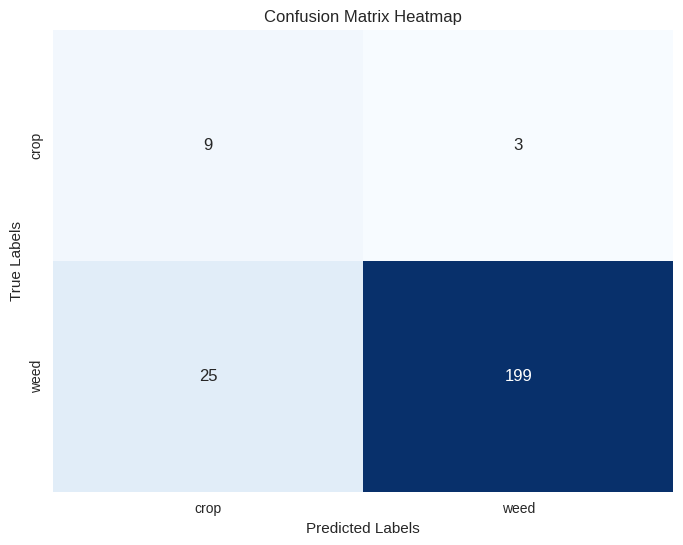

{'Accuracy sklearn': 0.8813559322033898,
 'Accuracy custom': 0.8813559322033898,
 'Conf Matrix': array([[  9,   3],
        [ 25, 199]]),
 'Recall crop': 0.75,
 'Recall weed': 0.8883928571428571,
 'Precision crop: (TP/(TP+FP))': 0.2647058823529412,
 'Precision weed': 0.9851485148514851,
 'F1 crop': 0.39130434782608703,
 'F1 weed': 0.9342723004694835,
 'F1 macro': 0.6627883241477852}

In [372]:
test_imbalanced_forest_classifier(X_combined, y_labels, class_weight={"crop": 1, "weed": 0.75})

This is the best performing model so far.

---

# What's next???

Cool, now that we have HOG, LBP and masked HSV, let's see if we can improve the previous random forest model.

---

# Imbalanced RandomForestClassifier - take 2

THis contains `HOG + LBP + HSV(masked)` images in the dataset.

In [440]:
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y_hog_labels,
    train_size=0.8,
    stratify=y_hog_labels # Fix imbalance
)

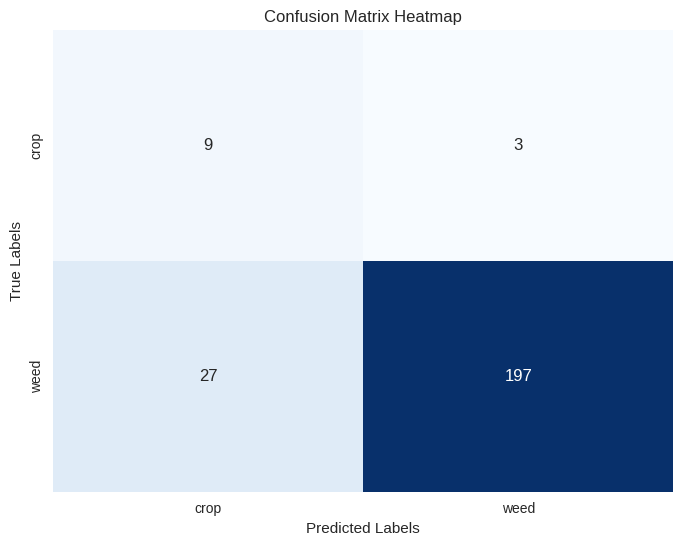

{'Accuracy sklearn': 0.8728813559322034,
 'Accuracy custom': 0.8728813559322034,
 'Conf Matrix': array([[  9,   3],
        [ 27, 197]]),
 'Recall crop': 0.75,
 'Recall weed': 0.8794642857142857,
 'Precision crop': 0.25,
 'Precision weed': 0.985,
 'F1 crop': 0.375,
 'F1 weed': 0.9292452830188679}

In [441]:
imb_rand_forest = BalancedRandomForestClassifier(n_estimators=100, sampling_strategy="majority", replacement=True)
imb_rand_forest.fit(X_train, y_train)
y_pred = imb_rand_forest.predict(X_test)
eval_mod.evaluate(y_test, y_pred, print_cnfm=True)

Not much improvement is happening on the model, this could be due to the curse of dimensionality. We have a total of 69754 features for each sample. This is waaay too much for the model to tweak. 

Here's the new plan:

1. Remove samples where the hue channel does not detect any plants.
2. Re-build reduced dataset 
3. Reduce nof HOG features on the new dataset
4. Rebuild X_combined
5. Retrain model

We should have less amount of features and the model should have an easier task of distinguishing crops from weeds.

---